# HMM for Carbon Emission Futures

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sklearn
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from hmmlearn import hmm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [4]:
def replace_outliers(df):
        for column in df.columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            outliers = (df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)
            detected_outliers = df[outliers]

            clean_data_iqr = df[~outliers].fillna(0)

            mean_value = clean_data_iqr[column].mean()
            noise = np.random.normal(0, 0.1, len(detected_outliers))
            mean_value_with_noise = noise + mean_value

            df.loc[outliers, column] = mean_value_with_noise
            
        
            # Calculate the percentage of detected outliers
            percentage_detected = (len(detected_outliers) / len(df)) * 100
            print(f"Column '{column}': Detected outliers: {percentage_detected:.2f}%")

        return df

In [5]:
def delete_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)
        detected_outliers = df[outliers]

        clean_data_iqr = df[~outliers].fillna(0)

        # Calculate the percentage of detected outliers
        percentage_detected = (len(detected_outliers) / len(df)) * 100
        print(f"Column '{column}': Detected outliers: {percentage_detected:.2f}%")

        # If you want to delete outliers, simply update the DataFrame
        df = clean_data_iqr

    return df

In [6]:
carbon_data = pd.read_csv('carbon_data_df_daily.csv', delimiter = ',' )

In [7]:
carbon_data

,Date,Carbon Price,Vol.,Oil,Coal Price,Gas,DAX
0,18/07/2006,17.70,NaN,73.540001,62.35,5.555,5396.850098
1,19/07/2006,17.20,NaN,72.660004,62.50,5.862,5539.290039
2,20/07/2006,17.55,NaN,73.080002,62.45,6.091,5545.819824
3,21/07/2006,17.40,NaN,74.430000,62.60,6.139,5451.009766
4,24/07/2006,17.30,NaN,75.050003,62.45,6.605,5578.049805
...,...,...,...,...,...,...,...
4197,11/08/2023,86.80,10.94,83.190002,116.50,2.770,15832.169922
4198,14/08/2023,87.95,13.26,82.510002,115.60,2.795,15904.250000
4199,16/08/2023,88.58,15.60,79.379997,115.85,2.592,15789.450195
4200,17/08/2023,88.85,15.80,80.389999,116.00,2.621,15676.900391


In [8]:
carbon_data = carbon_data.set_index('Date')
carbon_data.index = pd.to_datetime(carbon_data.index, format='%d/%m/%Y')
carbon_data = carbon_data.sort_index()

In [9]:
carbon_data = carbon_data[carbon_data.index >= '2008-01-01']

In [10]:
carbon_data_norm = feature_normalize(carbon_data)

In [11]:
correlation_matrix = carbon_data_norm.corr()

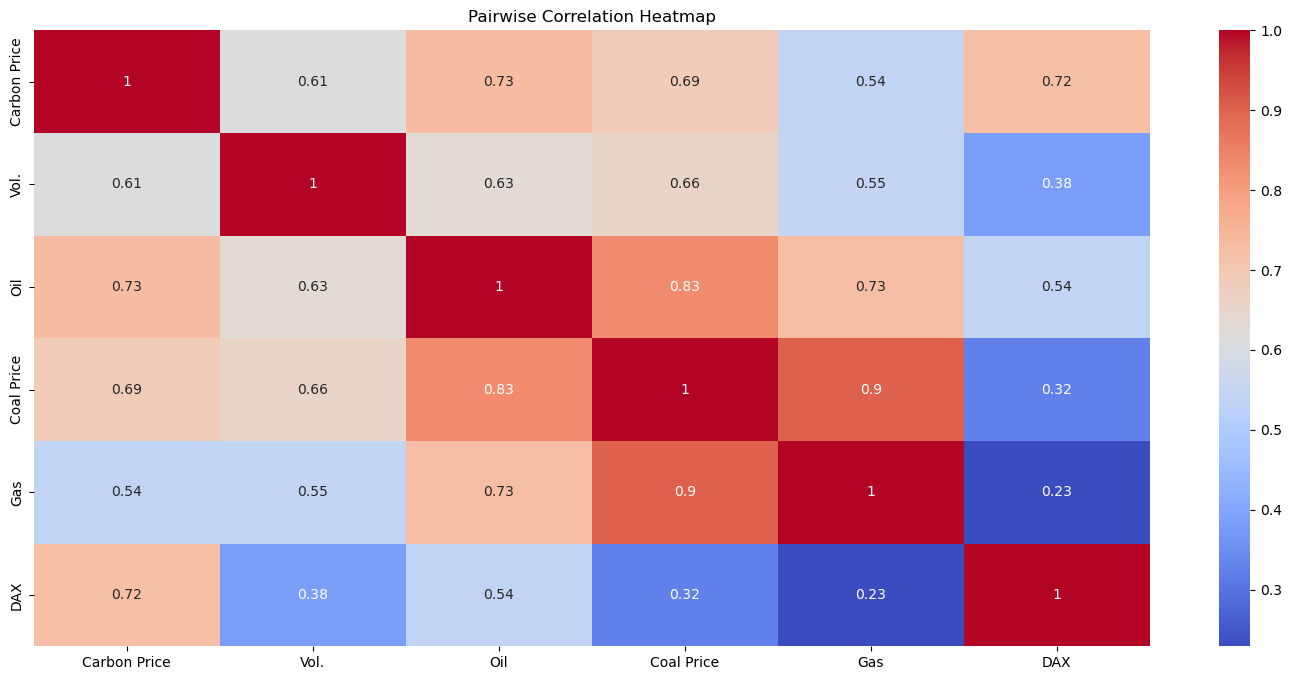

In [12]:
# Create the heatmap
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the plot title
plt.title('Pairwise Correlation Heatmap')

# Show the plot
plt.show()

In [11]:
# Calculating the difference between scaled columns
carbon_data_norm['Fuel Spread'] = carbon_data_norm['Coal Price'] - carbon_data_norm['Gas']

In [15]:
carbon_data_norm_scale = carbon_data_norm

In [13]:
#computing fuel spread after scaling and then adding to carbon df
scaler = MinMaxScaler()

# Scaling the columns
scaled_columns = scaler.fit_transform(carbon_data[['Gas', 'Coal Price']])
gas_scaled = scaled_columns[:, 0]
coal_price_scaled = scaled_columns[:, 1]


fuel_spread = gas_scaled - coal_price_scaled
carbon_data['Fuel Spread'] = fuel_spread

In [19]:
carbon_data_norm['Fuel Spread'] = carbon_data['Fuel Spread']

In [14]:
carbon_data

,Carbon Price,Vol.,Oil,Coal Price,Gas,DAX,Fuel Spread
Date,,,,,,,
2008-01-02,22.92,2.78,99.620003,127.75,7.850,7949.109863,0.303555
2008-01-03,23.54,3.31,99.180000,127.55,7.674,7908.410156,0.289503
2008-01-04,23.55,3.82,97.910004,129.00,7.841,7808.689941,0.299690
2008-01-07,23.66,4.15,95.089996,131.75,7.879,7817.169922,0.295967
2008-01-08,23.70,2.69,96.330002,130.75,7.967,7849.990234,0.305739
...,...,...,...,...,...,...,...
2023-08-11,86.80,10.94,83.190002,116.50,2.770,15832.169922,-0.088367
2023-08-14,87.95,13.26,82.510002,115.60,2.795,15904.250000,-0.084053
2023-08-16,88.58,15.60,79.379997,115.85,2.592,15789.450195,-0.101461


In [21]:
correlation_matrix = carbon_data.corr()

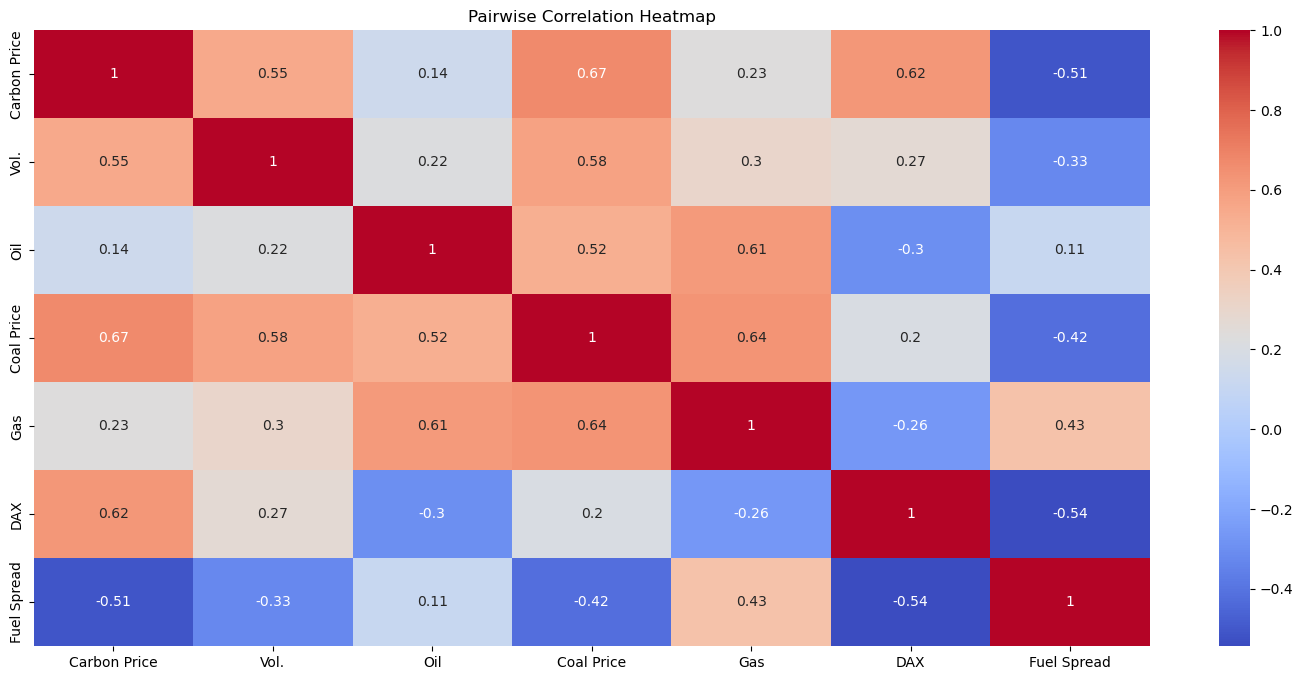

In [103]:
# Create the heatmap
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set the plot title
plt.title('Pairwise Correlation Heatmap')

# Show the plot
plt.show()

# PCA

In [12]:
carbon_data_norm = carbon_data_norm.dropna()

In [22]:
pca = PCA(n_components=0.95)
principalComponents = pca.fit_transform(carbon_data_norm)

In [23]:
components = pca.components_

In [24]:
components

array([[ 0.47814456,  0.41636857,  0.31166449,  0.55206471,  0.36164562,
         0.17046351,  0.19041909],
       [-0.29971423, -0.10647728,  0.45997339,  0.06552345,  0.48809887,
        -0.51590177, -0.42257541],
       [-0.22005231, -0.06928107,  0.47712126,  0.16204834, -0.45026349,
        -0.33942566,  0.61231182],
       [-0.28238669,  0.87896736, -0.19831373, -0.1407299 , -0.1020042 ,
        -0.27683274, -0.0387257 ],
       [-0.19721369, -0.18843711, -0.63965299,  0.51976545,  0.25114414,
        -0.33324968,  0.26862131]])

In [25]:
len(components)


5

In [66]:
explained_variance_ratio = pca.explained_variance_ratio_

In [67]:
explained_variance_ratio

array([0.44999446, 0.31381387, 0.08844068, 0.07704457, 0.04646546])

In [68]:
# Get the feature names from your original DataFrame
feature_names = carbon_data_norm.columns

# Create a DataFrame to store the feature names and weights for each principal component
components_df = pd.DataFrame(components, columns=feature_names)
components_df = components_df.fillna(0)

components_df_sorted = components_df.apply(lambda row: row.abs().nlargest(6), axis=1)

# Print the sorted features for each principal component
for i, component_features in enumerate(components_df_sorted.iterrows()):
    print(f"Principal Component {i+1}:")
    for feature, weight in component_features[1].items():
        print(f"Feature '{feature}': {weight:.4f}")
    print()

Principal Component 1:
Feature 'Carbon Price': 0.4781
Feature 'Coal Price': 0.5521
Feature 'DAX': nan
Feature 'Fuel Spread': 0.1904
Feature 'Gas': 0.3616
Feature 'Oil': 0.3117
Feature 'Vol.': 0.4164

Principal Component 2:
Feature 'Carbon Price': 0.2997
Feature 'Coal Price': nan
Feature 'DAX': 0.5159
Feature 'Fuel Spread': 0.4226
Feature 'Gas': 0.4881
Feature 'Oil': 0.4600
Feature 'Vol.': 0.1065

Principal Component 3:
Feature 'Carbon Price': 0.2201
Feature 'Coal Price': 0.1620
Feature 'DAX': 0.3394
Feature 'Fuel Spread': 0.6123
Feature 'Gas': 0.4503
Feature 'Oil': 0.4771
Feature 'Vol.': nan

Principal Component 4:
Feature 'Carbon Price': 0.2824
Feature 'Coal Price': 0.1407
Feature 'DAX': 0.2768
Feature 'Fuel Spread': nan
Feature 'Gas': 0.1020
Feature 'Oil': 0.1983
Feature 'Vol.': 0.8790

Principal Component 5:
Feature 'Carbon Price': 0.1972
Feature 'Coal Price': 0.5198
Feature 'DAX': 0.3332
Feature 'Fuel Spread': 0.2686
Feature 'Gas': 0.2511
Feature 'Oil': 0.6397
Feature 'Vol.': nan



In [69]:
components_df_sorted


,Carbon Price,Coal Price,DAX,Fuel Spread,Gas,Oil,Vol.
0,0.478145,0.552065,NaN,0.190419,0.361646,0.311664,0.416369
1,0.299714,NaN,0.515902,0.422575,0.488099,0.459973,0.106477
2,0.220052,0.162048,0.339426,0.612312,0.450263,0.477121,NaN
3,0.282387,0.140730,0.276833,NaN,0.102004,0.198314,0.878967
4,0.197214,0.519765,0.333250,0.268621,0.251144,0.639653,NaN


PCA (or any other linear method) is not a good choice. We need 5 components to achieve 95% explained variance.  

# t-SNE

In [26]:
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
    colors = sns.color_palette('tab20', n_colors=4)  # Choose a larger color palette

    for index, perplexity in enumerate(perplexities):
        # Perform t-SNE
        print('\nPerforming t-SNE with perplexity {} and {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')

        # Prepare the data for seaborn
        print('Creating plot for this t-SNE visualization..')
        df = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_data})
        df['label'] = df['label'].astype(int)

        # Get the unique levels in the 'label' column
        unique_labels = df['label'].unique()

        # Create a dictionary mapping each level to a color
        color_dict = dict(zip(unique_labels, colors[:len(unique_labels)]))

        # Map the colors to the 'label' column
        df['color'] = df['label'].map(color_dict)

In [26]:
X_reduced = TSNE(verbose=2, perplexity=20).fit_transform(X_tsne)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3470 samples in 0.007s...
[t-SNE] Computed neighbors for 3470 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3470
[t-SNE] Computed conditional probabilities for sample 2000 / 3470
[t-SNE] Computed conditional probabilities for sample 3000 / 3470
[t-SNE] Computed conditional probabilities for sample 3470 / 3470
[t-SNE] Mean sigma: 0.129358
[t-SNE] Computed conditional probabilities in 0.091s
[t-SNE] Iteration 50: error = 74.5029144, gradient norm = 0.0514098 (50 iterations in 0.511s)
[t-SNE] Iteration 100: error = 65.3111801, gradient norm = 0.0184818 (50 iterations in 0.473s)
[t-SNE] Iteration 150: error = 62.1524849, gradient norm = 0.0117788 (50 iterations in 0.468s)
[t-SNE] Iteration 200: error = 60.4552917, gradient norm = 0.0084209 (50 iterations in 0.481s)
[t-SNE] Iteration 250: error = 59.3920212, gradient norm = 0.0068628 (50 iterations in 0.477s)
[t-SNE] KL divergence after 250 iterati

In [34]:
perplexity, n_iter = 20,1000

In [29]:
colors = sns.color_palette('tab20', n_colors=4)  # Choose a larger color palette
# Prepare the data for seaborn
print('Creating plot for this t-SNE visualization..')
df = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_pre_tsne})
df['label'] = df['label'].astype(int)

# Get the unique levels in the 'label' column
unique_labels = df['label'].unique()

# Create a dictionary mapping each level to a color
color_dict = dict(zip(unique_labels, colors[:len(unique_labels)]))

# Map the colors to the 'label' column
df['color'] = df['label'].map(color_dict)

Creating plot for this t-SNE visualization..


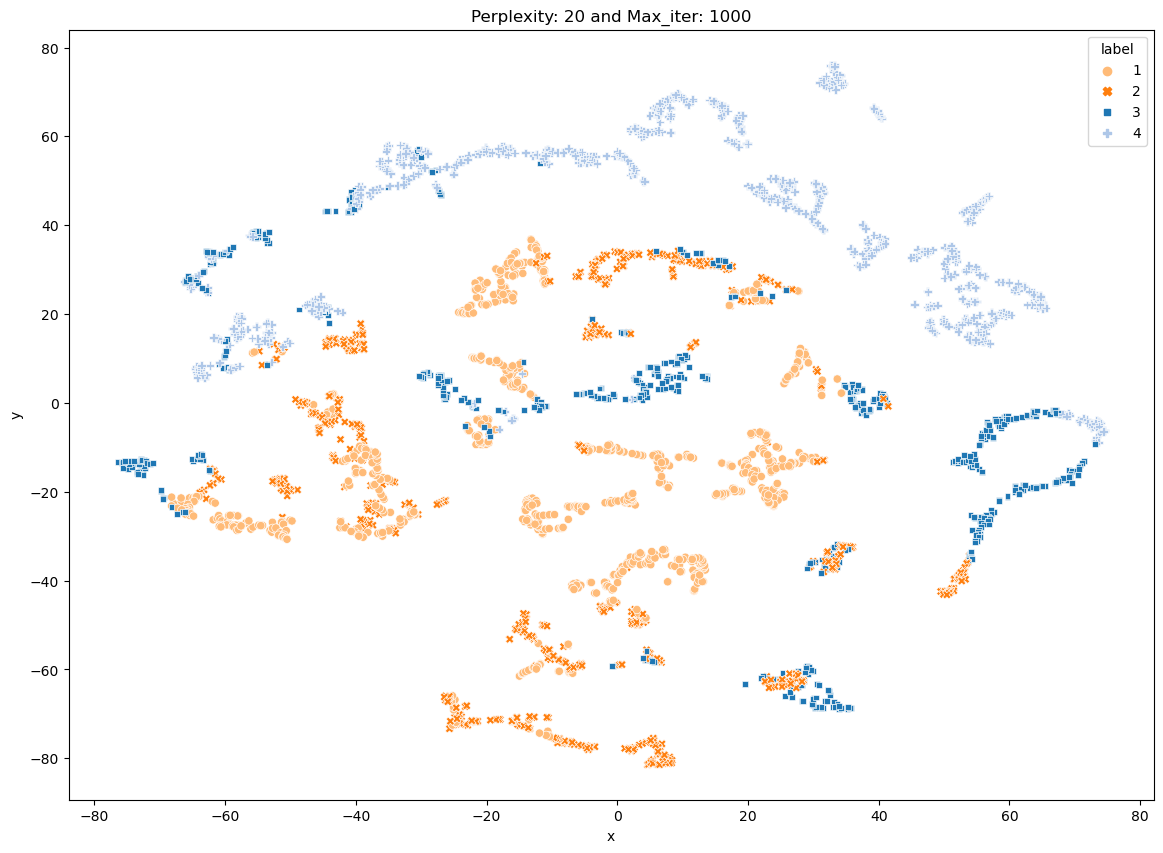

Done


In [36]:
# Draw the plot
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', style='label', palette=color_dict, markers=True)
plt.title("Perplexity: {} and Max_iter: {}".format(perplexity, n_iter))
# img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
# print('Saving this plot as an image in the present working directory...')
# plt.savefig(img_name)
plt.show()
print('Done')

Not surprisingly there is one clear class that can be separated nicely (if not perfectly) from the rest and that is label 4 (the majority of which are prices after 2019) 

In [ ]:
perform_tsne(X_data = X_tsne,y_data=y_pre_tsne, perplexities =[2,5,10,20,50])

In [39]:
def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
    colors = sns.color_palette('tab20', n_colors=4)  # Choose a larger color palette

    for index, perplexity in enumerate(perplexities):
        # Perform t-SNE
        print('\nPerforming t-SNE with perplexity {} and {} iterations at max'.format(perplexity, n_iter))
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('Done..')

        # Prepare the data for seaborn
        print('Creating plot for this t-SNE visualization..')
        df = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_data})
        df['label'] = df['label'].astype(int)

        # Get the unique levels in the 'label' column
        unique_labels = df['label'].unique()

        # Create a dictionary mapping each level to a color
        color_dict = dict(zip(unique_labels, colors[:len(unique_labels)]))

        # Map the colors to the 'label' column
        df['color'] = df['label'].map(color_dict)

        # Draw the plot
        plt.figure(figsize=(14, 10))
        sns.scatterplot(data=df, x='x', y='y', hue='label', style='label', palette=color_dict, markers=True)
        plt.title("Perplexity: {} and Max_iter: {}".format(perplexity, n_iter))
        img_name = img_name_prefix + '_perp_{}_iter_{}.png'.format(perplexity, n_iter)
        print('Saving this plot as an image in the present working directory...')
        plt.savefig(img_name)
        plt.show()
        print('Done')

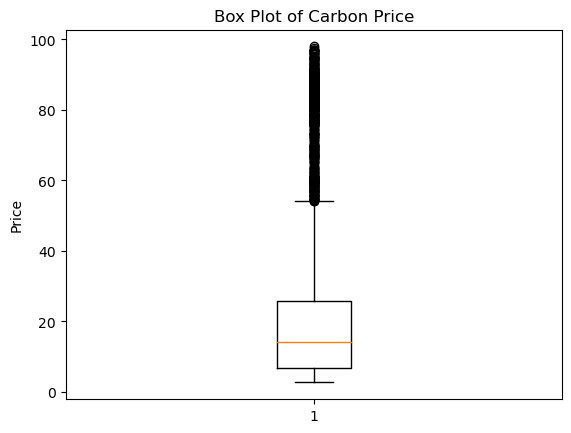

In [91]:
plt.boxplot(carbon_data['Carbon Price'])
plt.title('Box Plot of Carbon Price')
plt.ylabel('Price')
plt.show()

In [17]:
Q1 = carbon_data['Carbon Price'].quantile(0.25)
Q2 = carbon_data['Carbon Price'].quantile(0.50)
Q3 = carbon_data['Carbon Price'].quantile(0.75)

In [19]:
# Define the quantile intervals and labels
quantile_intervals = [float('-inf'), Q1, Q2, Q3, float('inf')]
labels = [1, 2, 3, 4]

# Use pd.cut() to categorize the data based on the intervals and labels
carbon_data['Quantile Labels'] = pd.cut(carbon_data['Carbon Price'], bins=quantile_intervals, labels=labels, include_lowest=True)

In [61]:
# Define the quantile intervals and labels
quantile_intervals = [float('-inf'), 6, 18, 35, float('inf')]
labels = [1, 2, 3, 4]

# Use pd.cut() to categorize the data based on the intervals and labels
carbon_data['Quantile Labels'] = pd.cut(carbon_data['Carbon Price'], bins=quantile_intervals, labels=labels, include_lowest=True)

In [20]:
carbon_data

,Carbon Price,Vol.,Oil,Coal Price,Gas,DAX,Fuel Spread,Quantile Labels
Date,,,,,,,,
2008-01-02,22.92,2.78,99.620003,127.75,7.850,7949.109863,0.303555,3
2008-01-03,23.54,3.31,99.180000,127.55,7.674,7908.410156,0.289503,3
2008-01-04,23.55,3.82,97.910004,129.00,7.841,7808.689941,0.299690,3
2008-01-07,23.66,4.15,95.089996,131.75,7.879,7817.169922,0.295967,3
2008-01-08,23.70,2.69,96.330002,130.75,7.967,7849.990234,0.305739,3
...,...,...,...,...,...,...,...,...
2023-08-11,86.80,10.94,83.190002,116.50,2.770,15832.169922,-0.088367,4
2023-08-14,87.95,13.26,82.510002,115.60,2.795,15904.250000,-0.084053,4
2023-08-16,88.58,15.60,79.379997,115.85,2.592,15789.450195,-0.101461,4


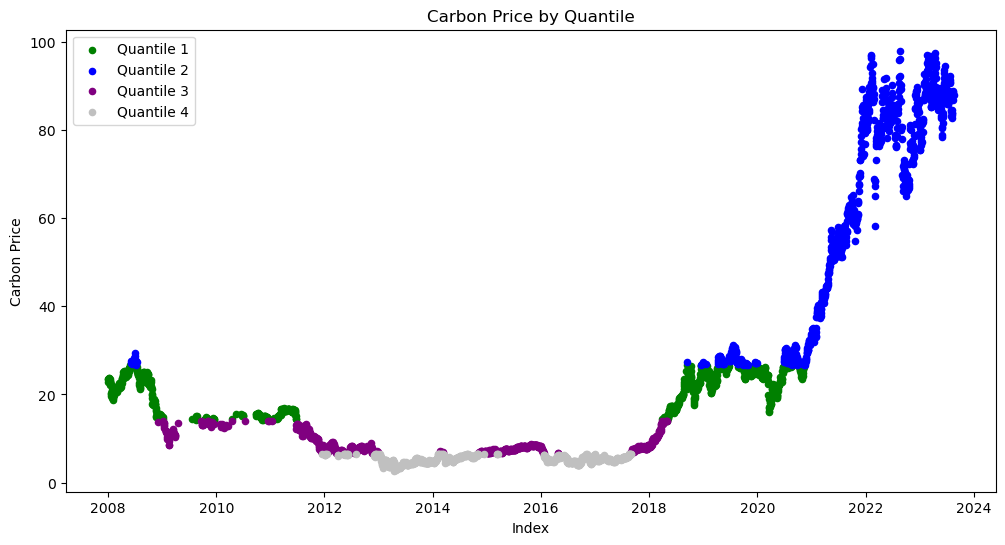

In [88]:
# Assuming you have 'carbon_data' DataFrame with 'Quantile Labels' and 'Carbon Price' columns

# Define neutral colors for each quantile label
quantile_colors = ['green', 'blue', 'purple', 'silver']  # Add more colors if needed


# Create a dictionary to store quantile label names and their corresponding colors
quantile_legend_mapping = {}
for label, color in zip(carbon_data['Quantile Labels'].unique(), quantile_colors):
    quantile_legend_mapping[f'Quantile {label}'] = color

plt.figure(figsize=(12, 6))

for label, color in quantile_legend_mapping.items():
    label_data = carbon_data[carbon_data['Quantile Labels'] == int(label.split()[1])]
    plt.scatter(label_data.index, label_data['Carbon Price'], s=20, marker='o', label=label, color=color)

# Sort legend entries based on quantile label names
sorted_legend = [label for label, _ in sorted(quantile_legend_mapping.items(), key=lambda x: int(x[0].split()[1]))]
plt.legend(sorted_legend)

plt.title('Carbon Price by Quantile')
plt.xlabel('Index')
plt.ylabel('Carbon Price')
plt.show()

In [21]:
carbon_data = carbon_data.dropna()
X_pre_tsne = carbon_data.drop(['Carbon Price','Fuel Spread','Quantile Labels'], axis=1)
X_tsne = feature_normalize(X_pre_tsne)
y_pre_tsne = carbon_data['Quantile Labels']

In [44]:
quantile_intervals

[-inf, 6.19, 9.85, 16.483999999999998, 27.63200000000001, inf]

In [22]:
y_pre_tsne

Date
2008-01-02    3
2008-01-03    3
2008-01-04    3
2008-01-07    3
2008-01-08    3
             ..
2023-08-11    4
2023-08-14    4
2023-08-16    4
2023-08-17    4
2023-08-18    4
Name: Quantile Labels, Length: 3470, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [23]:
len(y_pre_tsne)

3470

In [24]:
len(X_tsne)

3470


Performing t-SNE with perplexity 2 and 1000 iterations at max
[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 3470 samples in 0.005s...
[t-SNE] Computed neighbors for 3470 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3470
[t-SNE] Computed conditional probabilities for sample 2000 / 3470
[t-SNE] Computed conditional probabilities for sample 3000 / 3470
[t-SNE] Computed conditional probabilities for sample 3470 / 3470
[t-SNE] Mean sigma: 0.031087
[t-SNE] Computed conditional probabilities in 0.014s
[t-SNE] Iteration 50: error = 107.9401550, gradient norm = 0.0706524 (50 iterations in 0.655s)
[t-SNE] Iteration 100: error = 93.1639023, gradient norm = 0.0393972 (50 iterations in 0.400s)
[t-SNE] Iteration 150: error = 87.3997421, gradient norm = 0.0300795 (50 iterations in 0.391s)
[t-SNE] Iteration 200: error = 83.8126068, gradient norm = 0.0236495 (50 iterations in 0.378s)
[t-SNE] Iteration 250: error = 81.2537079, gradient norm = 0.0276807 (5

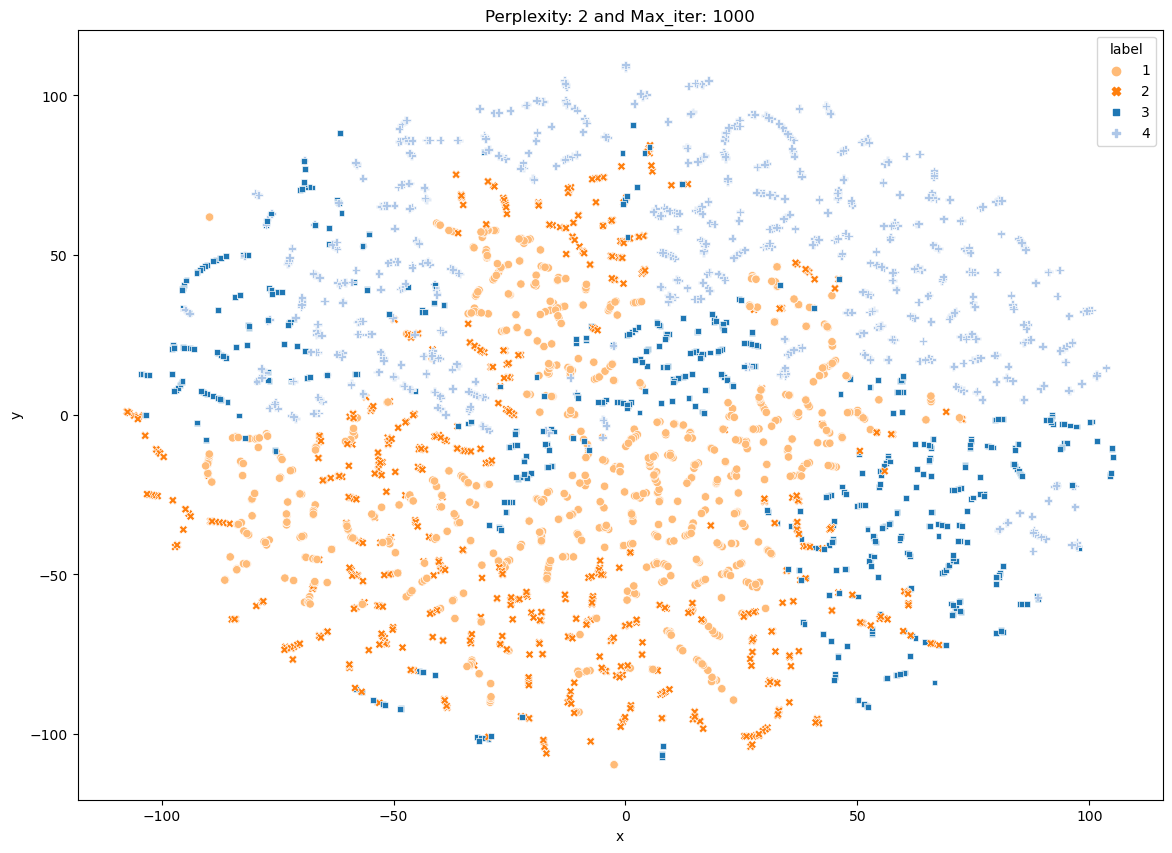

Done

Performing t-SNE with perplexity 5 and 1000 iterations at max
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3470 samples in 0.004s...
[t-SNE] Computed neighbors for 3470 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3470
[t-SNE] Computed conditional probabilities for sample 2000 / 3470
[t-SNE] Computed conditional probabilities for sample 3000 / 3470
[t-SNE] Computed conditional probabilities for sample 3470 / 3470
[t-SNE] Mean sigma: 0.063506
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 93.7439270, gradient norm = 0.0548753 (50 iterations in 0.467s)
[t-SNE] Iteration 100: error = 81.0076828, gradient norm = 0.0274088 (50 iterations in 0.361s)
[t-SNE] Iteration 150: error = 76.0638123, gradient norm = 0.0215507 (50 iterations in 0.365s)
[t-SNE] Iteration 200: error = 73.1135101, gradient norm = 0.0165891 (50 iterations in 0.375s)
[t-SNE] Iteration 250: error = 71.0852737, gradient norm = 0.01438

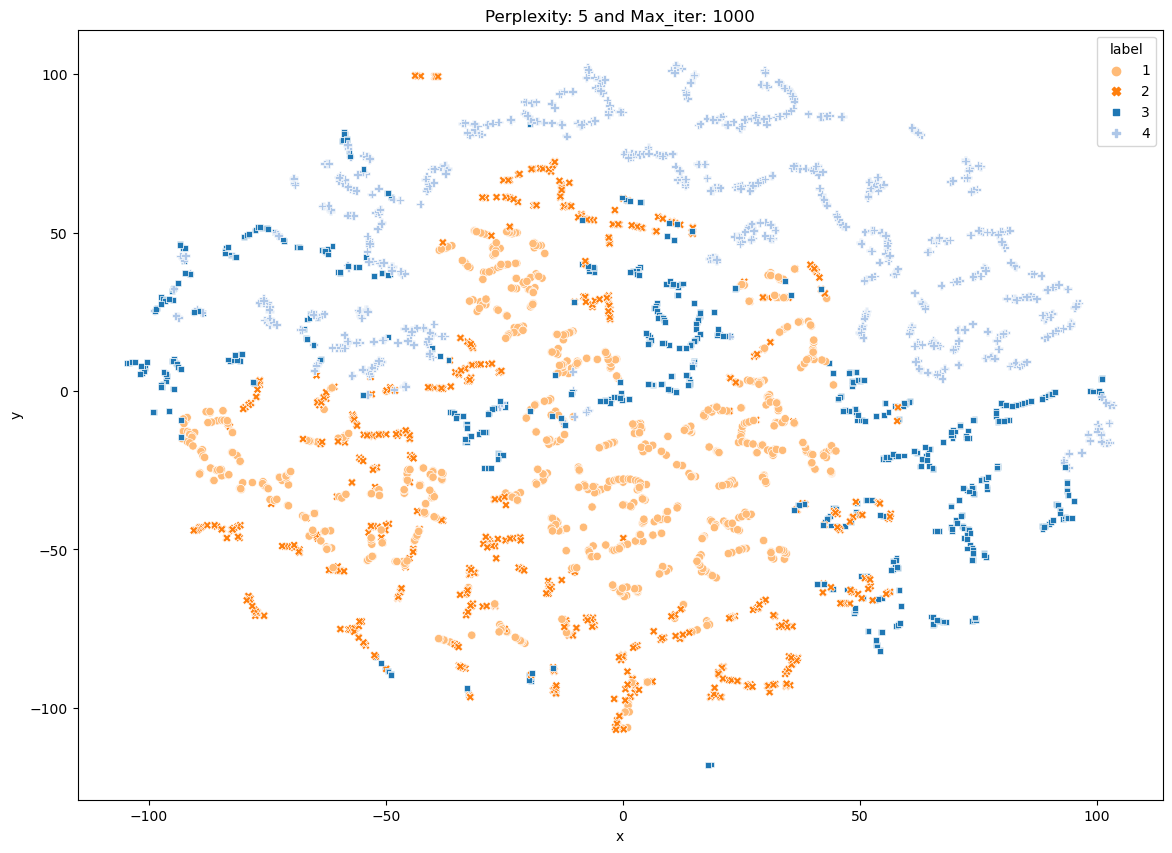

Done

Performing t-SNE with perplexity 10 and 1000 iterations at max
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3470 samples in 0.005s...
[t-SNE] Computed neighbors for 3470 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3470
[t-SNE] Computed conditional probabilities for sample 2000 / 3470
[t-SNE] Computed conditional probabilities for sample 3000 / 3470
[t-SNE] Computed conditional probabilities for sample 3470 / 3470
[t-SNE] Mean sigma: 0.092135
[t-SNE] Computed conditional probabilities in 0.045s
[t-SNE] Iteration 50: error = 83.3352509, gradient norm = 0.0444166 (50 iterations in 0.458s)
[t-SNE] Iteration 100: error = 72.3896790, gradient norm = 0.0219864 (50 iterations in 0.390s)
[t-SNE] Iteration 150: error = 68.3531952, gradient norm = 0.0142698 (50 iterations in 0.380s)
[t-SNE] Iteration 200: error = 66.0613403, gradient norm = 0.0124796 (50 iterations in 0.403s)
[t-SNE] Iteration 250: error = 64.5193710, gradient norm = 0.0098

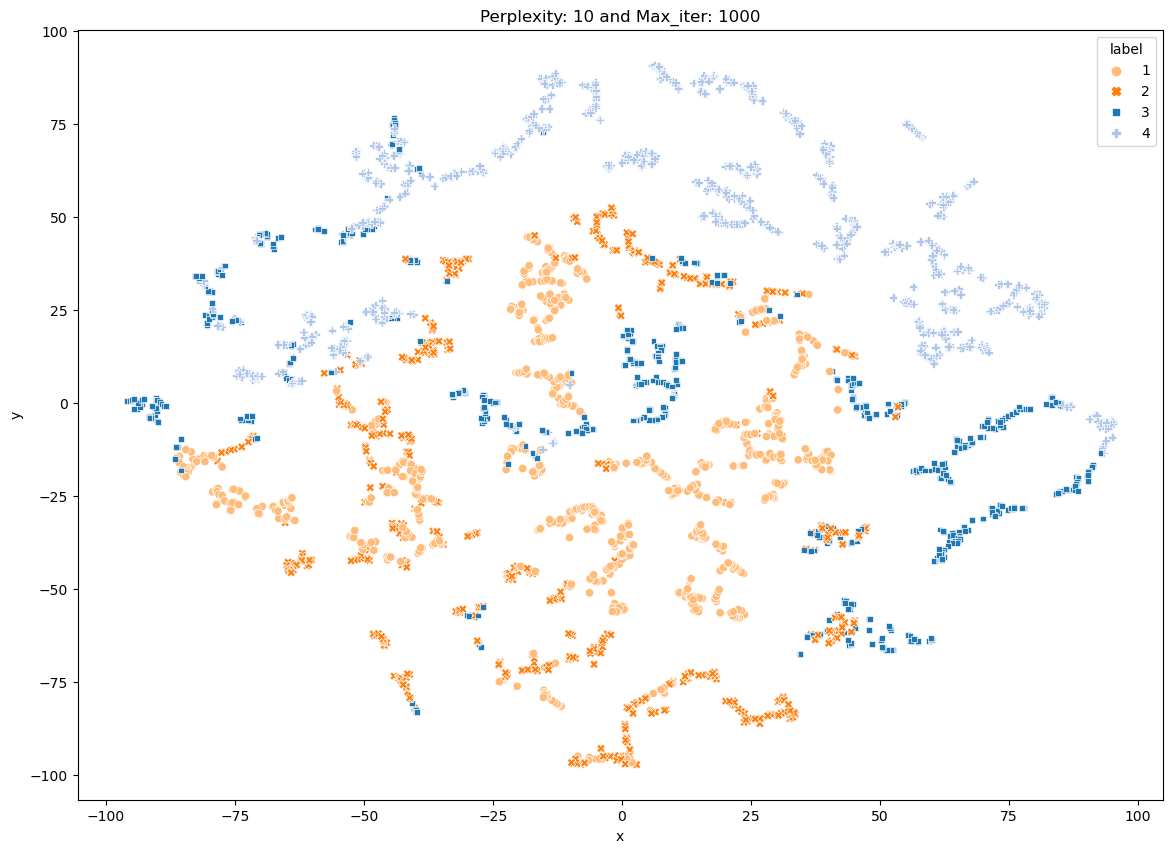

Done

Performing t-SNE with perplexity 20 and 1000 iterations at max
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3470 samples in 0.004s...
[t-SNE] Computed neighbors for 3470 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3470
[t-SNE] Computed conditional probabilities for sample 2000 / 3470
[t-SNE] Computed conditional probabilities for sample 3000 / 3470
[t-SNE] Computed conditional probabilities for sample 3470 / 3470
[t-SNE] Mean sigma: 0.129358
[t-SNE] Computed conditional probabilities in 0.085s
[t-SNE] Iteration 50: error = 74.5029144, gradient norm = 0.0514098 (50 iterations in 0.522s)
[t-SNE] Iteration 100: error = 65.3111801, gradient norm = 0.0184818 (50 iterations in 0.454s)
[t-SNE] Iteration 150: error = 62.1524849, gradient norm = 0.0117788 (50 iterations in 0.452s)
[t-SNE] Iteration 200: error = 60.4552917, gradient norm = 0.0084209 (50 iterations in 0.453s)
[t-SNE] Iteration 250: error = 59.3920212, gradient norm = 0.0068

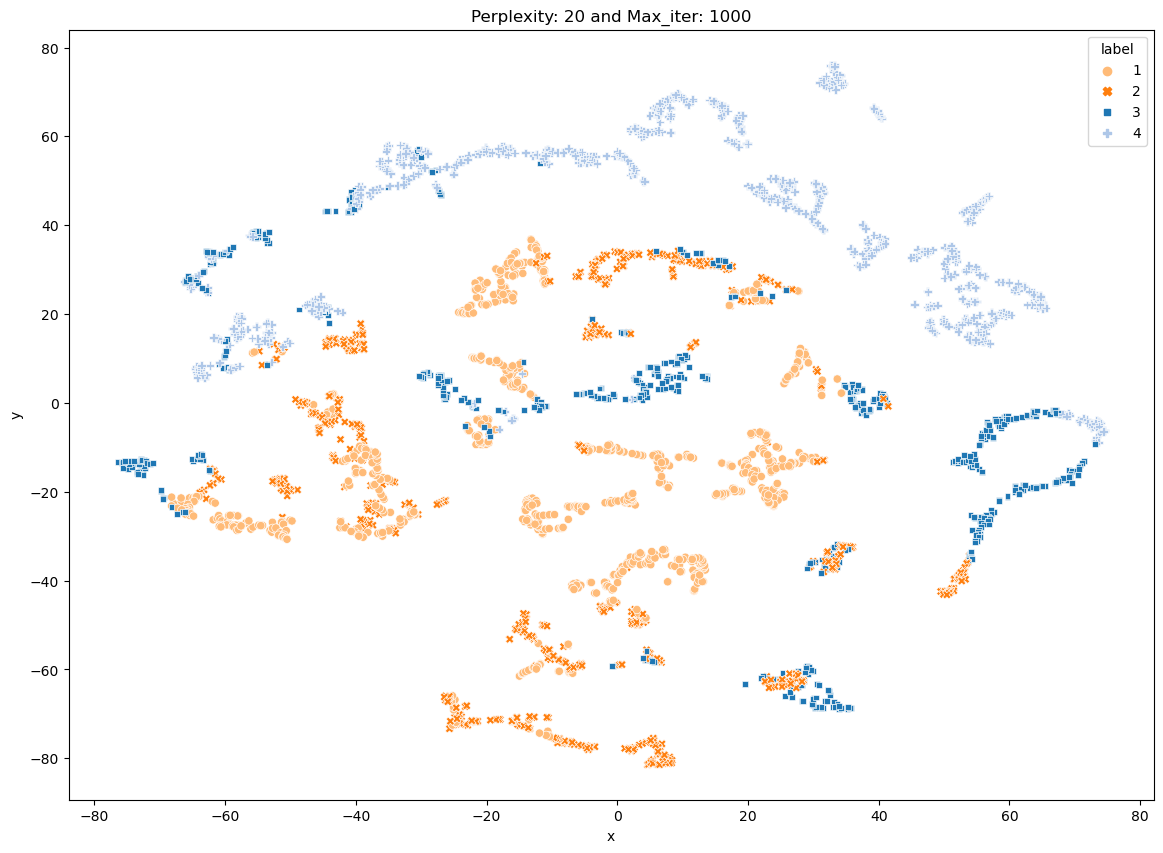

Done

Performing t-SNE with perplexity 50 and 1000 iterations at max
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3470 samples in 0.004s...
[t-SNE] Computed neighbors for 3470 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3470
[t-SNE] Computed conditional probabilities for sample 2000 / 3470
[t-SNE] Computed conditional probabilities for sample 3000 / 3470
[t-SNE] Computed conditional probabilities for sample 3470 / 3470
[t-SNE] Mean sigma: 0.196754
[t-SNE] Computed conditional probabilities in 0.205s
[t-SNE] Iteration 50: error = 64.9160385, gradient norm = 0.0335893 (50 iterations in 0.699s)
[t-SNE] Iteration 100: error = 58.4846992, gradient norm = 0.0106192 (50 iterations in 0.633s)
[t-SNE] Iteration 150: error = 56.7795029, gradient norm = 0.0064968 (50 iterations in 0.639s)
[t-SNE] Iteration 200: error = 55.9370270, gradient norm = 0.0048456 (50 iterations in 0.702s)
[t-SNE] Iteration 250: error = 55.4447174, gradient norm = 0.003

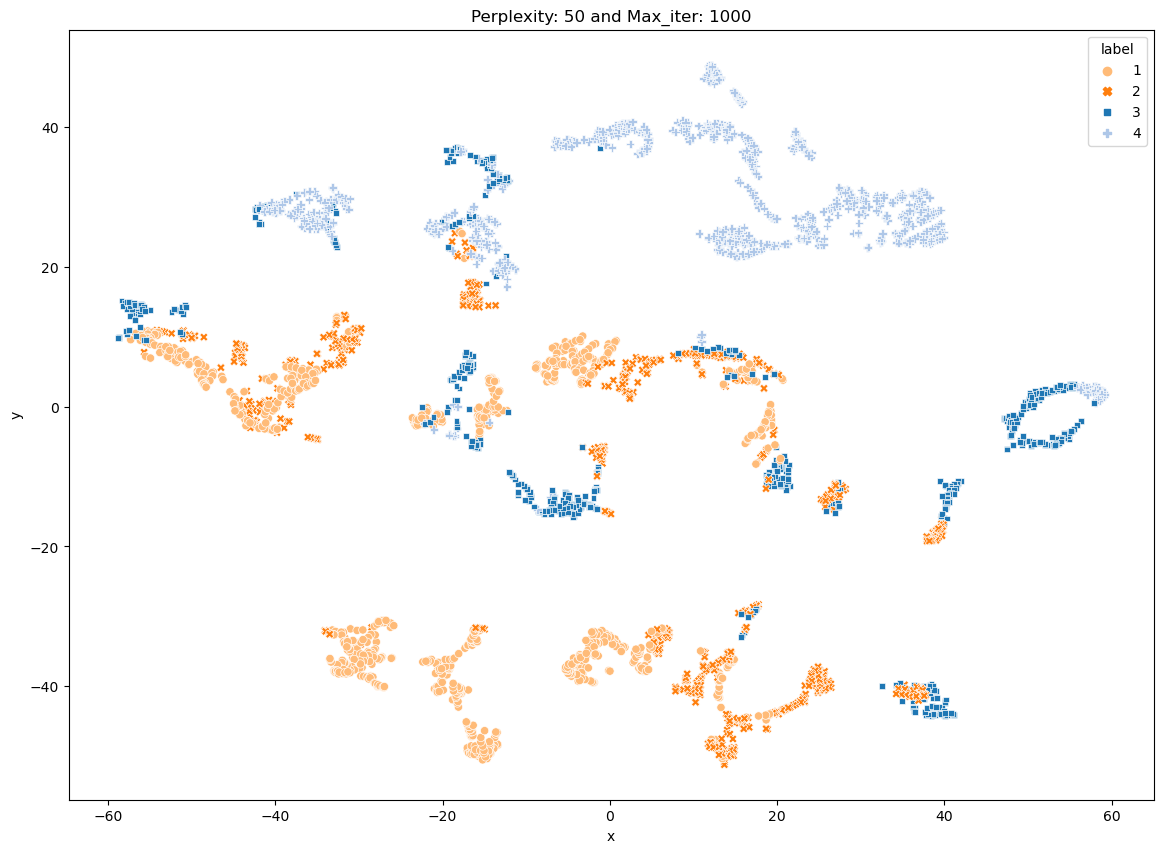

Done


In [64]:
perform_tsne(X_data = X_tsne,y_data=y_pre_tsne, perplexities =[2,5,10,20,50])

## Running regressions to determine relevant factors  

In [71]:
import statsmodels.api as sm

In [116]:
# Define the independent variables (features)
X = carbon_data_norm[['DAX', 'Coal Price', 'Oil', 'Vol.', 'Gas']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data_norm['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     1947.
Date:                Wed, 23 Aug 2023   Prob (F-statistic):               0.00
Time:                        22:58:53   Log-Likelihood:                -13861.
No. Observations:                3475   AIC:                         2.773e+04
Df Residuals:                    3469   BIC:                         2.777e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -49.2680      1.468    -33.566      0.0

In [120]:
# Define the independent variables (features)
X = carbon_data_norm[['Oil']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data_norm['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     75.68
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           5.07e-18
Time:                        23:03:45   Log-Likelihood:                -16146.
No. Observations:                3475   AIC:                         3.230e+04
Df Residuals:                    3473   BIC:                         3.231e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8536      1.354      9.490      0.0

In [116]:
# Define the independent variables (features)
X = carbon_data_norm[['DAX']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data_norm['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     2826.
Date:                Mon, 28 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:21:36   Log-Likelihood:                -4881.2
No. Observations:                4202   AIC:                             9766.
Df Residuals:                    4200   BIC:                             9779.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.168e-16      0.012   9.79e-15      1.0

In [105]:
carbon_data

,Date,Carbon Price,Vol.,Oil,Coal Price,Gas,DAX,Fuel Spread
355,19/12/2007,22.45,2.75,91.239998,127.50,7.179,7837.319824,0.160055
356,20/12/2007,22.30,1.92,91.059998,127.75,7.137,7869.189941,0.135153
357,21/12/2007,21.93,1.69,93.309998,127.75,7.190,8002.669922,0.112325
358,27/12/2007,21.87,1.33,96.620003,127.70,7.172,8038.600098,0.108061
359,28/12/2007,22.21,0.59,96.000000,127.75,7.386,8067.319824,0.110526
...,...,...,...,...,...,...,...,...
4197,11/08/2023,86.80,10.94,83.190002,116.50,2.770,15832.169922,NaN
4198,14/08/2023,87.95,13.26,82.510002,115.60,2.795,15904.250000,NaN
4199,16/08/2023,88.58,15.60,79.379997,115.85,2.592,15789.450195,NaN
4200,17/08/2023,88.85,15.80,80.389999,116.00,2.621,15676.900391,NaN


In [117]:
# Define the independent variables (features)
X = carbon_data_norm[['Coal Price']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data_norm['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     3292.
Date:                Mon, 28 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:21:49   Log-Likelihood:                -4746.3
No. Observations:                4202   AIC:                             9497.
Df Residuals:                    4200   BIC:                             9509.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.168e-16      0.012   1.01e-14      1.0

In [118]:
# Define the independent variables (features)
X = carbon_data_norm[['Gas']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data_norm['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     47.31
Date:                Mon, 28 Aug 2023   Prob (F-statistic):           6.97e-12
Time:                        17:22:05   Log-Likelihood:                -5938.8
No. Observations:                4202   AIC:                         1.188e+04
Df Residuals:                    4200   BIC:                         1.189e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.168e-16      0.015   7.61e-15      1.0

In [166]:
# Define the independent variables (features)
X = carbon_data_norm[['DAX', 'Coal Price']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data_norm['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     4362.
Date:                Mon, 28 Aug 2023   Prob (F-statistic):               0.00
Time:                        21:58:47   Log-Likelihood:                -3174.0
No. Observations:                3842   AIC:                             6354.
Df Residuals:                    3839   BIC:                             6373.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.946e-16      0.009    3.3e-14      1.0

In [165]:
carbon_data = carbon_data.dropna()

In [113]:
# Define the independent variables (features)
X = carbon_data[['Fuel Spread']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     1069.
Date:                Mon, 28 Aug 2023   Prob (F-statistic):          2.77e-198
Time:                        17:12:53   Log-Likelihood:                -9166.7
No. Observations:                2749   AIC:                         1.834e+04
Df Residuals:                    2747   BIC:                         1.835e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.4399      0.130     95.997      

In [72]:
# Define the independent variables (features)
X = carbon_data[['Fuel Spread']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     1347.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):          4.32e-253
Time:                        15:30:12   Log-Likelihood:                -17156.
No. Observations:                3842   AIC:                         3.432e+04
Df Residuals:                    3840   BIC:                         3.433e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          26.7917      0.354     75.625      

In [73]:
# Define the independent variables (features)
X = carbon_data_norm[['DAX', 'Fuel Spread']]

# Add a constant term to the predictor matrix (required by statsmodels)
X = sm.add_constant(X)

# Define the dependent variable
y = carbon_data_norm['Carbon Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Carbon Price   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     1402.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:30:19   Log-Likelihood:                -4041.1
No. Observations:                3470   AIC:                             8088.
Df Residuals:                    3467   BIC:                             8107.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0548      0.013     -4.114      

Linear regression is in fact not recommended as the correlations are obviously not linear. This can be seen in the next plots

<Axes: xlabel='Carbon Price', ylabel='Fuel Spread'>

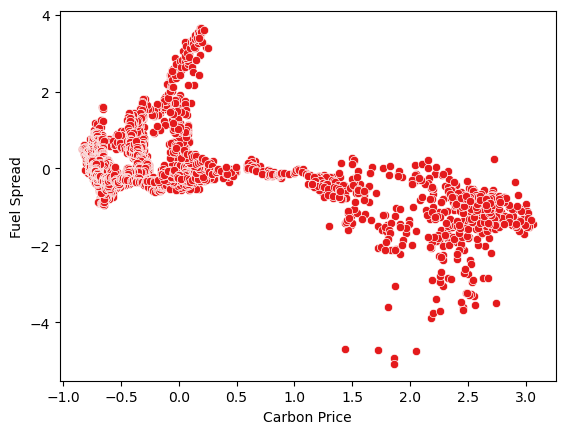

In [160]:
sns.scatterplot(x=carbon_data_norm['Carbon Price'],y=carbon_data_norm['Fuel Spread'])  

<Axes: xlabel='Carbon Price', ylabel='DAX'>

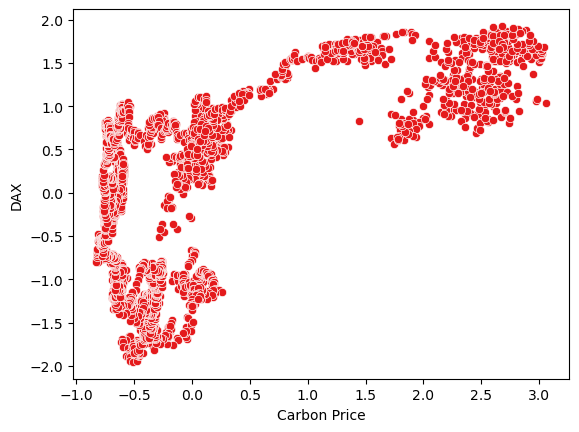

In [161]:
sns.scatterplot(x=carbon_data_norm['Carbon Price'],y=carbon_data_norm['DAX'])  

<Axes: xlabel='Carbon Price', ylabel='Coal Price'>

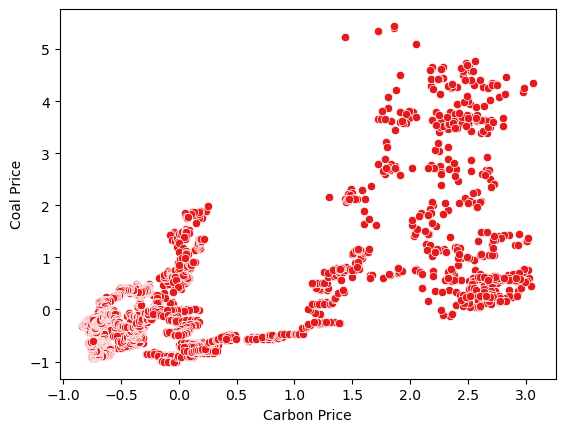

In [162]:
sns.scatterplot(x=carbon_data_norm['Carbon Price'],y=carbon_data_norm['Coal Price']) 

# Forecasting prices with HMM

In [117]:
import numpy as np
import pandas as pd
import json as js
from yahoo_finance import Share
import datetime as dt


class HMM(object):
    # Implements discrete 1-st order Hidden Markov Model 

    def __init__(self, tolerance = 1e-6, max_iterations=10000, scaling=True):
        self.tolerance=tolerance
        self.max_iter = max_iterations
        self.scaling = scaling

    def HMMfwd(self, a, b, o, pi):
        # Implements HMM Forward algorithm
        N = np.shape(b)[0]
        T = np.shape(o)[0]

        alpha = np.zeros((N, T))
        # Initialize first column with observation values
        alpha[:, 0] = pi * b[:, o[0]]
        c = np.ones((T))

        if self.scaling:
            c[0] = 1.0 / np.sum(alpha[:, 0])
            alpha[:, 0] = alpha[:, 0] * c[0]

            for t in range(1, T):
                c[t] = 0
                for i in range(N):
                    alpha[i, t] = b[i, o[t]] * np.sum(alpha[:, t - 1] * a[:, i])
                c[t] = 1.0 / np.sum(alpha[:, t])
                alpha[:, t] = alpha[:, t] * c[t]

        else:
            for t in range(1, T):
                for i in range(N):
                    alpha[i, t] = b[i, o[t]] * np.sum(alpha[:, t - 1] * a[:, i])

        return alpha, c

    def HMMbwd(self, a, b, o, c):
        # Implements HMM Backward algorithm
    
        N = np.shape(b)[0]
        T = np.shape(o)[0]
    
        beta = np.zeros((N,T))
        # initialise last row with scaling c
        beta[:,T-1] = c[T-1]
    
        for t in range(T-2,-1,-1):
            for i in range(N):
                beta[i,t] = np.sum(b[:,o[t+1]] * beta[:,t+1] * a[i,:])
            # scale beta by the same value as a
            beta[:,t]=beta[:,t]*c[t]

        return beta

    def HMMViterbi(self, a, b, o, pi):
        # Implements HMM Viterbi algorithm        
        
        N = np.shape(b)[0]
        T = np.shape(o)[0]
    
        path = np.zeros(T)
        delta = np.zeros((N,T))
        phi = np.zeros((N,T))
    
        delta[:,0] = pi * b[:,o[0]]
        phi[:,0] = 0
    
        for t in range(1,T):
            for i in range(N):
                delta[i,t] = np.max(delta[:,t-1]*a[:,i])*b[i,o[t]]
                phi[i,t] = np.argmax(delta[:,t-1]*a[:,i])
    
        path[T-1] = np.argmax(delta[:,T-1])
        for t in range(T-2,-1,-1):
            path[t] = phi[int(path[t+1]),t+1]
    
        return path,delta, phi

 
    def HMMBaumWelch(self, o, N, dirichlet=False, verbose=False, rand_seed=1):
        # Implements HMM Baum-Welch algorithm        
        T = np.shape(o)[0]
        M = int(max(o)) + 1  # now all hist time-series will contain all observation vals, but we have to provide for all

        digamma = np.zeros((1, N, T))
        

        # Initialization can be done either using the Dirichlet distribution (all randoms sum to one) 
        # or using approximates uniforms from matrix sizes
        if dirichlet:
            pi = np.random.dirichlet(np.ones(N), size=1)
            a = np.random.dirichlet(np.ones(N), size=N)
            b = np.random.dirichlet(np.ones(M), size=N)
        else:
            pi_randomizer = np.random.dirichlet(np.ones(N), size=1) / 100
            pi = 1.0 / N * np.ones(N) - pi_randomizer

            a_randomizer = np.random.dirichlet(np.ones(N), size=N) / 100
            a = 1.0 / N * np.ones([N, N]) - a_randomizer

            b_randomizer = np.random.dirichlet(np.ones(M), size=N) / 100
            b = 1.0 / M * np.ones([N, M]) - b_randomizer

        error = self.tolerance + 10
        itter = 0
        while error > self.tolerance and itter < self.max_iter:

            prev_a = a.copy()
            prev_b = b.copy()

            # Estimate model parameters
            alpha, c = self.HMMfwd(a, b, o, pi)
            beta = self.HMMbwd(a, b, o, c)

            for t in range(T - 1):
                for i in range(N):
                    for j in range(N):
                        digamma[i, j, t] = alpha[i, t] * a[i, j] * b[j, o[t + 1]] * beta[j, t + 1]
                digamma[:, :, t] /= np.sum(digamma[:, :, t])

            for i in range(N):
                for j in range(N):
                    digamma[i, j, T - 1] = alpha[i, T - 1] * a[i, j]
            digamma[:, :, T - 1] /= np.sum(digamma[:, :, T - 1])

            # Maximize parameter expectation
            for i in range(N):
                pi[i] = np.sum(digamma[i, :, 0])
                for j in range(N):
                    a[i, j] = np.sum(digamma[i, j, :T - 1]) / np.sum(digamma[i, :, :T - 1])
                for k in range(M):
                    filter_vals = (o == k).nonzero()
                    b[i, k] = np.sum(digamma[i, :, filter_vals]) / np.sum(digamma[i, :, :])

            error = (np.abs(a - prev_a)).max() + (np.abs(b - prev_b)).max()
            itter += 1

            if verbose:
                print("Iteration: ", itter, " error: ", error, "P(O|lambda): ", np.sum(alpha[:, T - 1]))

        return a, b, pi, alpha

In [39]:
np_hist_prices = carbon_data.values

In [42]:
carbon_data

,Carbon Price,Vol.,Oil,Coal Price,Gas,DAX
Date,,,,,,
2008-01-02,22.92,2.78,99.620003,127.75,7.850,7949.109863
2008-01-03,23.54,3.31,99.180000,127.55,7.674,7908.410156
2008-01-04,23.55,3.82,97.910004,129.00,7.841,7808.689941
2008-01-07,23.66,4.15,95.089996,131.75,7.879,7817.169922
2008-01-08,23.70,2.69,96.330002,130.75,7.967,7849.990234
...,...,...,...,...,...,...
2023-08-11,86.80,10.94,83.190002,116.50,2.770,15832.169922
2023-08-14,87.95,13.26,82.510002,115.60,2.795,15904.250000
2023-08-16,88.58,15.60,79.379997,115.85,2.592,15789.450195


In [88]:
def computeMoves(datafram, holding_period=1):
    np_observations = dataframe.values
    moves = np_observations[holding_period:] - np_observations[:-holding_period]
    return moves

In [49]:
carbon_prices_moves = computeMoves(carbon_data)

In [50]:
carbon_prices_moves

array([[6.20000000e-01, 5.30000000e-01, 4.40002441e-01, 2.00000000e-01,
        1.76000118e-01, 4.06997070e+01],
       [1.00000000e-02, 5.10000000e-01, 1.26999664e+00, 1.45000000e+00,
        1.67000294e-01, 9.97202148e+01],
       [1.10000000e-01, 3.30000000e-01, 2.82000732e+00, 2.75000000e+00,
        3.80001068e-02, 8.47998047e+00],
       ...,
       [6.30000000e-01, 2.34000000e+00, 3.13000488e+00, 2.50000000e-01,
        2.03000069e-01, 1.14799805e+02],
       [2.70000000e-01, 2.00000000e-01, 1.01000214e+00, 1.50000000e-01,
        2.90000439e-02, 1.12549805e+02],
       [8.00000000e-01, 2.94000000e+00, 8.60000610e-01, 7.50000000e-01,
        6.99999332e-02, 1.02640625e+02]])

In [ ]:
hist_O = np.array(list(map(lambda x: 1 if x > 0 else (0 if x < 0 else 2), carbon_prices_moves)))

In [67]:
# Define a function to apply the logic element-wise to each column
def label_columns(arr):
    result = np.zeros_like(arr, dtype=int)
    result[arr > 0] = 1
    result[arr < 0] = 0
    result[arr == 0] = 2
    return result

# Apply the function to the entire array
moves_binarized = label_columns(carbon_prices_moves)

In [68]:
moves_binarized

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [72]:
moves_binarized_carbon = moves_binarized[:,0]

In [73]:
moves_binarized_rev = moves_binarized_carbon[::-1]

In [76]:
moves_binarized_rev.shape

(3841,)

In [74]:
hmm = HMM()
   
# Train the HMM using Baum-Welch algorithm
(a, b, pi_est, alpha_est) = hmm.HMMBaumWelch(moves_binarized_rev, 3, False, True)

# Use Viterbi to predict hidden states
(path, delta, phi) = hmm.HMMViterbi(a, b, moves_binarized_rev, pi_est)

Iteration:  1  error:  0.6620135969921551 P(O|lambda):  0.9999999999999998
Iteration:  2  error:  2.2677443672902697e-07 P(O|lambda):  1.0


In [77]:

    # Now use the path to make price predictions
    predicted_prices = []
    for state in path:
        # Adjust these factors based on your domain knowledge and context
        if state == 0:  # Down state
            predicted_prices.append(current_price * 0.95)  # Example: Decrease by 5%
        elif state == 1:  # Up state
            predicted_prices.append(current_price * 1.05)  # Example: Increase by 5%
        else:  # Unchanged state
            predicted_prices.append(current_price)  # No change
    
    # Print or analyze the predicted prices
    for i, price in enumerate(predicted_prices):
        print(f"Predicted Price for Day {i+1}: {price}")

NameError: name 'current_price' is not defined

In [10]:
current_price =  hist_prices[-1]

In [13]:
current_price = 450

In [12]:
hist_prices

array([[1.83198593e+02, 1.83350006e+02, 7.38384000e+05, ...,
        1.81449997e+02, 1.85229996e+02, 4.46799000e+07],
       [1.87574951e+02, 1.87729996e+02, 7.38385000e+05, ...,
        1.81830002e+02, 1.83009995e+02, 4.15447000e+07],
       [1.78342590e+02, 1.78490005e+02, 7.38386000e+05, ...,
        1.77699997e+02, 1.84059998e+02, 4.41588000e+07],
       ...,
       [4.23880005e+02, 4.23880005e+02, 7.38742000e+05, ...,
        4.18350006e+02, 4.21600006e+02, 4.92705000e+07],
       [4.08549988e+02, 4.08549988e+02, 7.38743000e+05, ...,
        4.06390015e+02, 4.17510010e+02, 5.32009000e+07],
       [4.37529999e+02, 4.37529999e+02, 7.38746000e+05, ...,
        4.03109985e+02, 4.04859985e+02, 6.90286000e+07]])

In [15]:
path

array([1., 2., 2., 2., 2., 0., 1., 1., 2., 2., 2., 0., 1., 2., 0., 1., 2.,
       2., 2., 0., 1., 2., 0., 1., 1., 0., 1., 2., 2., 0., 1., 2., 0., 1.,
       2., 2., 2., 2., 0., 1., 2., 0., 1., 1., 0., 1., 2., 2., 2., 0., 1.,
       2., 0., 1., 1., 2., 2., 2., 2., 0., 1., 0., 1., 2., 0., 1., 2., 0.,
       1., 2., 2., 2., 0., 1., 0., 1., 2., 0., 1., 2., 0., 1., 0., 1., 2.,
       2., 2., 0., 1., 2., 2., 0., 1., 0., 1., 2., 2., 2., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 2., 0., 1., 2., 2., 0., 1., 2., 0., 1., 2., 0.,
       1., 2., 2., 2., 2., 0., 1., 2., 0., 1., 1., 2., 2., 0., 1., 1., 2.,
       0., 1., 0., 1., 0., 1., 2., 2., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       2., 0., 1., 2., 2., 2., 0., 1., 2., 2., 2., 2., 2., 0., 1., 2., 0.,
       1., 2., 2., 2., 0., 1., 2., 2., 2., 0., 1., 2., 2., 2., 0., 1., 2.,
       0., 1., 2., 0., 1., 0., 1., 0., 1., 2., 0., 1., 2., 0., 1., 1., 0.,
       1., 0., 1., 0., 1., 2., 2., 2., 2., 2., 0., 1., 1., 2., 2., 0., 1.,
       2., 2., 0., 1., 2.

In [134]:
hmm = HMM()

test_start_date = '2021-08-17'
test_end_date = '2023-08-15'
all_data = hist_prices = parseStockPrices(test_start_date, test_end_date, 'NVDA')
assert len(all_data)>0, "Houston, we've got a problem"


num_correct=0.0
test_window = 6
N=len(all_data)
num_tests=N/test_window
for n in range(1,N-test_window,test_window):
    train_data = all_data[-n:-n-test_window:-1,:]
    hist_moves = calculateDailyMoves(train_data,1)
    hist_O=np.array(list(map(lambda x: 1 if x>0 else (0 if x<0 else 2), hist_moves)))
    hist_O = hist_O[::-1]
    (a, b, pi_est, alpha_est) = hmm.HMMBaumWelch(hist_O, 2, False, False)
    (path, delta, phi)=hmm.HMMViterbi(a, b, hist_O, pi_est)
    path = path.astype(int)
    prediction_state=np.argmax(a[path[-1],:])
    prediction = np.argmax(b[prediction_state,:])
    if ((all_data[-n-test_window-1,1]-all_data[-n-test_window,1])>0 and prediction==1) or ((all_data[-n-test_window-1,1]-all_data[-n-test_window,1])<0 and prediction==0) or ((all_data[-n-test_window-1,1]-all_data[-n-test_window,1])==0 and prediction==2):
        num_correct+=1.0
print (num_correct/num_tests)

[*********************100%***********************]  1 of 1 completed


IndexError: index 1 is out of bounds for axis 0 with size 1

In [101]:
import numpy as np

def computeMoves(dataarray, holding_period=1):
    moves = dataarray[holding_period:] - dataarray[:-holding_period]
    return moves

# Define a function to apply the logic element-wise to each column
def label_columns(arr):
    result = np.zeros_like(arr, dtype=int)
    result[arr > 0] = 1
    result[arr < 0] = 0
    result[arr == 0] = 2
    return result

# Apply the function to the entire array
moves_binarized = label_columns(carbon_prices_moves)

In [102]:
moves_binarized

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [138]:
# Assuming 'all_data' is a NumPy array with multiple columns
all_data = carbon_data[['Carbon Price']].values  # Extracting the 'Carbon Price' column as a NumPy array

hmm = HMM()

num_correct = 0.0
test_window = 6
N = len(all_data)
num_tests = N // test_window  # Use integer division (//) for the number of tests

In [139]:
all_data

array([[22.92],
       [23.54],
       [23.55],
       ...,
       [88.58],
       [88.85],
       [88.05]])

In [140]:
n = 10

In [147]:
    train_data = all_data[-n:-n-test_window:-1]
    hist_moves = computeMoves(train_data, 1)  # Assuming holding_period=1 for daily moves
    hist_O = label_columns(hist_moves)
    hist_O = hist_O[::-1]
    hist_O = hist_O.ravel()

In [148]:
 hist_O

array([0, 0, 0, 0, 1])

In [149]:
hist_O.ravel()

array([0, 0, 0, 0, 1])

In [153]:
    (a, b, pi_est, alpha_est) = hmm.HMMBaumWelch(hist_O, 2, False, False)

ValueError: could not broadcast input array from shape (2,2) into shape (2,)

In [146]:
    (a, b, pi_est, alpha_est)

(array([[9.99997295e-01, 2.70461953e-06],
        [6.20523497e-01, 3.79476503e-01]]),
 array([[2.95120186e-01, 7.04879814e-01],
        [2.02805440e-35, 1.00000000e+00]]),
 array([3.68018855e-17, 1.00000000e+00]),
 array([[4.17491891e-17, 5.35450775e-01, 7.67094537e-01, 1.00000000e+00,
         9.99995177e-01],
        [1.00000000e+00, 4.64549225e-01, 2.32905463e-01, 2.82023627e-35,
         4.82287286e-06]]))

In [152]:
    (path, delta, phi) = hmm.HMMViterbi(a, b, hist_O, pi_est)

ValueError: could not broadcast input array from shape (2,2) into shape (2,)

In [154]:
for n in range(1, N - test_window, test_window):
    train_data = all_data[-n:-n-test_window:-1]
    hist_moves = computeMoves(train_data, 1)  # Assuming holding_period=1 for daily moves
    hist_O = label_columns(hist_moves)
    hist_O = hist_O[::-1]
    hist_O = hist_O.ravel()
    # Assuming 2 hidden states and no Dirichlet randomization
    (a, b, pi_est, alpha_est) = hmm.HMMBaumWelch(hist_O, 2, False, False)
    (path, delta, phi) = hmm.HMMViterbi(a, b, hist_O, pi_est)
    path = path.astype(int)
    prediction_state = np.argmax(a[path[-1], :])
    prediction = np.argmax(b[prediction_state, :])
    
    # Assuming you want to predict based on the 'Carbon Price' column
    price_difference = all_data[-n-test_window-1, 0] - all_data[-n-test_window, 0]
    
    if ((price_difference > 0 and prediction == 1) or 
        (price_difference < 0 and prediction == 0) or 
        (price_difference == 0 and prediction == 2)):
        num_correct += 1.0

print(num_correct / num_tests)

0.484375


In [132]:
    def HMMBaumWelch(self, o, N, dirichlet=False, verbose=False, rand_seed=1):
        # Implements HMM Baum-Welch algorithm        
        T = np.shape(o)[0]
        M = int(max(o)) + 1  # now all hist time-series will contain all observation vals, but we have to provide for all

        digamma = np.zeros((N, N, T))

        # Initialize A, B, and pi randomly, but so that they sum to one
        np.random.seed(rand_seed)

        # Initialization can be done either using the Dirichlet distribution (all randoms sum to one) 
        # or using approximates uniforms from matrix sizes
        if dirichlet:
            pi = np.random.dirichlet(np.ones(N), size=1)
            a = np.random.dirichlet(np.ones(N), size=N)
            b = np.random.dirichlet(np.ones(M), size=N)
        else:
            pi_randomizer = np.random.dirichlet(np.ones(N), size=1) / 100
            pi = 1.0 / N * np.ones(N) - pi_randomizer

            a_randomizer = np.random.dirichlet(np.ones(N), size=N) / 100
            a = 1.0 / N * np.ones([N, N]) - a_randomizer

            b_randomizer = np.random.dirichlet(np.ones(M), size=N) / 100
            b = 1.0 / M * np.ones([N, M]) - b_randomizer

        error = self.tolerance + 10
        itter = 0
        while error > self.tolerance and itter < self.max_iter:

            prev_a = a.copy()
            prev_b = b.copy()

            # Estimate model parameters
            alpha, c = self.HMMfwd(a, b, o, pi)
            beta = self.HMMbwd(a, b, o, c)

            for t in range(T - 1):
                for i in range(N):
                    for j in range(N):
                        digamma[i, j, t] = alpha[i, t] * a[i, j] * b[j, o[t + 1]] * beta[j, t + 1]
                digamma[:, :, t] /= np.sum(digamma[:, :, t])

            for i in range(N):
                for j in range(N):
                    digamma[i, j, T - 1] = alpha[i, T - 1] * a[i, j]
            digamma[:, :, T - 1] /= np.sum(digamma[:, :, T - 1])

            # Maximize parameter expectation
            for i in range(N):
                pi[i] = np.sum(digamma[i, :, 0])
                for j in range(N):
                    a[i, j] = np.sum(digamma[i, j, :T - 1]) / np.sum(digamma[i, :, :T - 1])
                for k in range(M):
                    filter_vals = (o == k).nonzero()
                    b[i, k] = np.sum(digamma[i, :, filter_vals]) / np.sum(digamma[i, :, :])

            error = (np.abs(a - prev_a)).max() + (np.abs(b - prev_b)).max()
            itter += 1

            if verbose:
                print("Iteration: ", itter, " error: ", error, "P(O|lambda): ", np.sum(alpha[:, T - 1]))

        return a, b, pi, alpha

In [80]:
all_data = carbon_data['Carbon Price']

In [81]:
all_data[-n:-n-test_window:-1,:]

KeyError: 'key of type tuple not found and not a MultiIndex'

In [79]:
carbon_data['Carbon Price']

Date
2008-01-02    22.92
2008-01-03    23.54
2008-01-04    23.55
2008-01-07    23.66
2008-01-08    23.70
              ...  
2023-08-11    86.80
2023-08-14    87.95
2023-08-16    88.58
2023-08-17    88.85
2023-08-18    88.05
Name: Carbon Price, Length: 3842, dtype: float64

In [24]:
print(path.dtype)

float64


In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

In [28]:
# Collect true labels (based on next-day market move)
true_labels = np.array([(1 if (all_data[-n-test_window-1,1]-all_data[-n-test_window,1]) > 0 else 0) for n in range(1, N-test_window, test_window)])

# Collect probabilities (scores) for the positive class (modify this part)
scores = []  # Replace with actual scores

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, scores)

# Calculate AUC
auc = roc_auc_score(true_labels, scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [83, 0]

In [29]:
scores

[]

In [137]:
hmm = HMM()

test_start_date = '2021-08-17'
test_end_date = '2023-08-15'
all_data = hist_prices = parseStockPrices(test_start_date, test_end_date, 'NVDA')
assert len(all_data)>0, "Houston, we've got a problem"


num_correct=0.0
test_window = 6
N=len(all_data)
num_tests=N/test_window
for n in range(1,N-test_window,test_window):
    train_data = all_data[-n:-n-test_window:-1,:]
    hist_moves = calculateDailyMoves(train_data,1)
    hist_O=np.array(list(map(lambda x: 1 if x>0 else (0 if x<0 else 2), hist_moves)))
    hist_O = hist_O[::-1]
    (a, b, pi_est, alpha_est) = hmm.HMMBaumWelch(hist_O, 2, False, False)
    (path, delta, phi)=hmm.HMMViterbi(a, b, hist_O, pi_est)
    path = path.astype(int)
    prediction_state=np.argmax(a[path[-1],:])
    prediction = np.argmax(b[prediction_state,:])
    if ((all_data[-n-test_window-1,1]-all_data[-n-test_window,1])>0 and prediction==1) or ((all_data[-n-test_window-1,1]-all_data[-n-test_window,1])<0 and prediction==0) or ((all_data[-n-test_window-1,1]-all_data[-n-test_window,1])==0 and prediction==2):
        num_correct+=1.0
print (num_correct/num_tests)

[*********************100%***********************]  1 of 1 completed
0.49101796407185627


In [136]:
import numpy as np
import pandas as pd
import json as js
from yahoo_finance import Share
import datetime as dt


class HMM(object):
    # Implements discrete 1-st order Hidden Markov Model 

    def __init__(self, tolerance = 1e-6, max_iterations=10000, scaling=True):
        self.tolerance=tolerance
        self.max_iter = max_iterations
        self.scaling = scaling

    def HMMfwd(self, a, b, o, pi):
        # Implements HMM Forward algorithm
    
        N = np.shape(b)[0]
        T = np.shape(o)[0]
    
        alpha = np.zeros((N,T))
        # initialise first column with observation values
        alpha[:,0] = pi*b[:,o[0]]
        c = np.ones((T))
        
        if self.scaling:
            
            c[0]=1.0/np.sum(alpha[:,0])
            alpha[:,0]=alpha[:,0]*c[0]
            
            for t in range(1,T):
                c[t]=0
                for i in range(N):
                    alpha[i,t] = b[i,o[t]] * np.sum(alpha[:,t-1] * a[:,i])
                c[t]=1.0/np.sum(alpha[:,t])
                alpha[:,t]=alpha[:,t]*c[t]

        else:
            for t in range(1,T):
                for i in range(N):
                    alpha[i,t] = b[i,o[t]] * np.sum(alpha[:,t-1] * a[:,i])
        
        return alpha, c

    def HMMbwd(self, a, b, o, c):
        # Implements HMM Backward algorithm
    
        N = np.shape(b)[0]
        T = np.shape(o)[0]
    
        beta = np.zeros((N,T))
        # initialise last row with scaling c
        beta[:,T-1] = c[T-1]
    
        for t in range(T-2,-1,-1):
            for i in range(N):
                beta[i,t] = np.sum(b[:,o[t+1]] * beta[:,t+1] * a[i,:])
            # scale beta by the same value as a
            beta[:,t]=beta[:,t]*c[t]

        return beta

    def HMMViterbi(self, a, b, o, pi):
        # Implements HMM Viterbi algorithm        
        
        N = np.shape(b)[0]
        T = np.shape(o)[0]
    
        path = np.zeros(T)
        delta = np.zeros((N,T))
        phi = np.zeros((N,T))
    
        delta[:,0] = pi * b[:,o[0]]
        phi[:,0] = 0
    
        for t in range(1,T):
            for i in range(N):
                delta[i,t] = np.max(delta[:,t-1]*a[:,i])*b[i,o[t]]
                phi[i,t] = np.argmax(delta[:,t-1]*a[:,i])
    
        path[T-1] = np.argmax(delta[:,T-1])
        for t in range(T-2,-1,-1):
            path[t] = phi[int(path[t+1]),t+1]
    
        return path,delta, phi

 
    def HMMBaumWelch(self, o, N, dirichlet=False, verbose=False, rand_seed=1):
        # Implements HMM Baum-Welch algorithm        
        
        T = np.shape(o)[0]

        M = int(max(o))+1 # now all hist time-series will contain all observation vals, but we have to provide for all

        digamma = np.zeros((N,N,T))

    
        # Initialise A, B and pi randomly, but so that they sum to one
        np.random.seed(rand_seed)
        
        # Initialisation can be done either using dirichlet distribution (all randoms sum to one) 
        # or using approximates uniforms from matrix sizes
        if dirichlet:
            pi = np.ndarray.flatten(np.random.dirichlet(np.ones(N),size=1))
            
            a = np.random.dirichlet(np.ones(N),size=N)
            
            b=np.random.dirichlet(np.ones(M),size=N)
        else:
            
            pi_randomizer = np.ndarray.flatten(np.random.dirichlet(np.ones(N),size=1))/100
            pi=1.0/N*np.ones(N)-pi_randomizer

            a_randomizer = np.random.dirichlet(np.ones(N),size=N)/100
            a=1.0/N*np.ones([N,N])-a_randomizer

            b_randomizer=np.random.dirichlet(np.ones(M),size=N)/100
            b = 1.0/M*np.ones([N,M])-b_randomizer

        
        error = self.tolerance+10
        itter = 0
        while ((error > self.tolerance) & (itter < self.max_iter)):   

            prev_a = a.copy()
            prev_b = b.copy()
    
            # Estimate model parameters
            alpha, c = self.HMMfwd(a, b, o, pi)
            beta = self.HMMbwd(a, b, o, c) 
    
            for t in range(T-1):
                for i in range(N):
                    for j in range(N):
                        digamma[i,j,t] = alpha[i,t]*a[i,j]*b[j,o[t+1]]*beta[j,t+1]
                digamma[:,:,t] /= np.sum(digamma[:,:,t])
    

            for i in range(N):
                for j in range(N):
                    digamma[i,j,T-1] = alpha[i,T-1]*a[i,j]
            digamma[:,:,T-1] /= np.sum(digamma[:,:,T-1])
    
            # Maximize parameter expectation
            for i in range(N):
                pi[i] = np.sum(digamma[i,:,0])
                for j in range(N):
                    a[i,j] = np.sum(digamma[i,j,:T-1])/np.sum(digamma[i,:,:T-1])
                for k in range(M):
                    filter_vals = (o==k).nonzero()
                    b[i,k] = np.sum(digamma[i,:,filter_vals])/np.sum(digamma[i,:,:])
    
            error = (np.abs(a-prev_a)).max() + (np.abs(b-prev_b)).max() 
            itter += 1            
            
            if verbose:            
                print ("Iteration: ", itter, " error: ", error, "P(O|lambda): ", np.sum(alpha[:,T-1]))
    
        return a, b, pi, alpha
        

def parseStockPrices(from_date, to_date, symbol):
    df = pdr.get_data_yahoo(symbol, start=from_date, end=to_date)

    np_hist_prices = np.empty(shape=[len(df), 7])
    for i, (_, row) in enumerate(df.iterrows()):
        np_hist_prices[i, 0] = row['Adj Close']
        np_hist_prices[i, 1] = row['Close']
        np_hist_prices[i, 2] = row.name.toordinal()
        np_hist_prices[i, 3] = row['High']
        np_hist_prices[i, 4] = row['Low']
        np_hist_prices[i, 5] = row['Open']
        np_hist_prices[i, 6] = row['Volume']

    return np_hist_prices
         
        
def calculateDailyMoves(hist_prices, holding_period):
    # calculate daily moves as absolute difference between close_(t+1) - close_(t)    

    assert holding_period > 0, "Holding period should be above zero"
    return (hist_prices[:-holding_period,1]-hist_prices[holding_period:,1])